In [58]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Parameters

In [9]:
# parameters
INITIAL_PRICE = 200
MAX_T = 150
PROB_PRICE = 0.2
PROB_PRICE_UP = PROB_PRICE
PROB_PRICE_DOWN = PROB_PRICE
PROB_UNINFORMED = 0.1
PROB_UNINFORMED_BUY = PROB_UNINFORMED
PROB_UNINFORMED_SELL = PROB_UNINFORMED
PROB_INFORMED = 0.4
ALL_PROB = [PROB_PRICE_UP, PROB_PRICE_DOWN, PROB_UNINFORMED_SELL, PROB_UNINFORMED_BUY, PROB_INFORMED]

In [10]:
np.sum(ALL_PROB)

1.0

In [11]:
EVENT_PRICE_CHANGE_UP = 0
EVENT_PRICE_CHANGE_DOWN = 1
EVENT_UNINFORMED_BUY = 2
EVENT_UNINFORMED_SELL = 3
EVENT_INFORMED_ARRIVAL = 4

In [13]:
 ALL_EVENT = [EVENT_PRICE_CHANGE_UP, EVENT_PRICE_CHANGE_DOWN, EVENT_UNINFORMED_SELL, EVENT_UNINFORMED_BUY, EVENT_INFORMED_ARRIVAL]

In [14]:
 ALL_EVENT

[0, 1, 3, 2, 4]

- numpy.random.choice(a, size=None, replace=True, p=None)

- 从a(只要是ndarray都可以，但必须是一维的)中随机抽取数字，并组成指定大小(size)的数组

- replace:True表示可以取相同数字，False表示不可以取相同数字

- 数组p：与数组a相对应，表示取数组a中每个元素的概率，默认为选取每个元素的概率相同。

## Fundamental Prices Simulations

In [15]:
# Simulating the Poisson process
def simulate_events(probabilities=ALL_PROB):
    return np.random.choice(ALL_EVENT, p=probabilities, size=MAX_T)

In [16]:
events = simulate_events()
events[:10]

array([4, 4, 1, 2, 0, 2, 4, 0, 3, 0])

In [17]:
"""
#  Simulating the price process
fundamental_price_changes = np.zeros(MAX_T)
fundamental_price_changes[events == EVENT_PRICE_CHANGE_DOWN] = -1
fundamental_price_changes[events == EVENT_PRICE_CHANGE_UP] = +1

fundamental_price_changes[:10]
"""

array([ 0.,  0., -1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.])

In [19]:
"""
len(events),len(fundamental_price_changes)
"""

(150, 150)

In [20]:
"""
fundamental_price = INITIAL_PRICE + np.cumsum(fundamental_price_changes)
fundamental_price[:10]
"""

array([200., 200., 199., 199., 200., 200., 200., 201., 201., 202.])

In [21]:
# Simulating fundamental prices as a function
def simulate_fundamental_price(events):
    price_changes = np.zeros(MAX_T)
    price_changes[events == EVENT_PRICE_CHANGE_DOWN] = -1
    price_changes[events == EVENT_PRICE_CHANGE_UP] = +1
    return INITIAL_PRICE + np.cumsum(price_changes)

fundamental_price = simulate_fundamental_price(events)
fundamental_price[:10]

array([200., 200., 199., 199., 200., 200., 200., 201., 201., 202.])

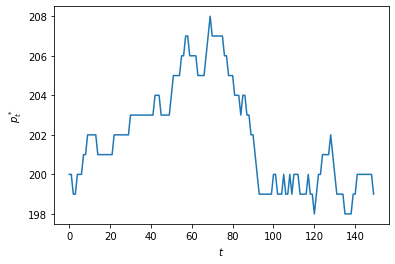

In [23]:
plt.plot(fundamental_price)
plt.xlabel('$t$'); plt.ylabel('$p_t^*$')
plt.show()

## Uninformed Traders

In [24]:
def simulate_uninformed_orders(events):
    orders = np.zeros(MAX_T)
    orders[events == EVENT_UNINFORMED_BUY] = +1
    orders[events == EVENT_UNINFORMED_SELL] = -1
    return orders
uninformed_orders = simulate_uninformed_orders(events)
uninformed_orders[:10]

array([ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0., -1.,  0.])

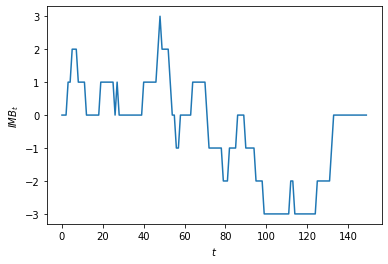

In [25]:
plt.plot(np.cumsum(uninformed_orders))
plt.xlabel('$t$'); plt.ylabel('$IMB_t$')
plt.show()

## Informed Traders

In [26]:
def informed_strategy(current_price, mm_price):
    if current_price > mm_price:
        return 1
    elif current_price < mm_price:
        return -1
    else:
        return 0

## A simple market-making strategy


In [27]:
# 追涨杀跌at threshold
def mm_threshold_strategy(order_imbalance, threshold=2):
    if order_imbalance == -threshold:
        return -1
    elif order_imbalance == +threshold:
        return +1
    else:
        return 0

## The reward function


In [28]:
def mm_reward(current_fundamental_price, mm_current_price, order_sign):
    if order_sign < 0:
        return current_fundamental_price - mm_current_price
    elif order_sign > 0:
        return mm_current_price - current_fundamental_price
    else:
        return 0

## The market simulation

In [29]:
def simulate_market(events, uninformed_orders, fundamental_price, mm_strategy=mm_threshold_strategy, threshold=1):
    
    mm_prices = np.zeros(MAX_T)        # market-maker price history
    order_imbalances = np.zeros(MAX_T) # order-imbalance histort
    informed_orders = np.zeros(MAX_T)  # newly coming informed trader orders
    rewards = np.zeros(MAX_T)          # market-maker reward history
    actions = np.zeros(MAX_T)          # action history
    t_mm = 0                           # the time of the last market-maker's action
    mm_current_price = INITIAL_PRICE
    
    for t in range(MAX_T):
        if events[t] == EVENT_INFORMED_ARRIVAL:
            order = informed_strategy(fundamental_price[t], mm_current_price)
            informed_orders[t] = order             # new order of informed trader added into the informed_orders
        else:
            order = uninformed_orders[t]   
            
        # order-imbalance made by both informed and uninformed orders together (a scaler)
        imbalance = np.sum(informed_orders[t_mm:t] + uninformed_orders[t_mm:t])  
        
        # the market-maker price change
        mm_price_delta = mm_strategy(imbalance, threshold)
        
        # if market-maker make a price change: mark the time and change the price
        if mm_price_delta != 0:
            t_mm = t
            mm_current_price += mm_price_delta
            
        order_imbalances[t] = imbalance
        mm_prices[t] = mm_current_price
        actions[t] = mm_price_delta
        rewards[t] = mm_reward(fundamental_price[t], mm_current_price, order)

    return mm_prices, order_imbalances, rewards, actions


In [30]:
mm_prices, order_imbalances, rewards, actions = simulate_market(events, uninformed_orders, fundamental_price, threshold=2)

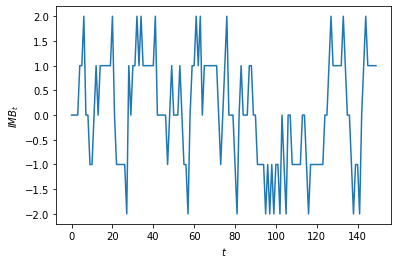

In [32]:
# Order-imbalance time series
plt.plot(order_imbalances)
plt.xlabel('$t$')
plt.ylabel('$IMB_t$')
plt.show()

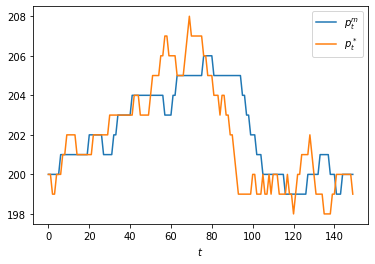

In [33]:
# Price time series
plt.plot(mm_prices)
plt.plot(fundamental_price)
plt.xlabel('$t$')
plt.legend(['$p^m_t$','$p^*_t$'])
plt.show()

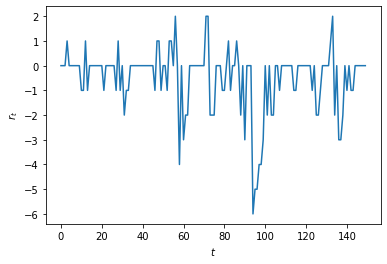

In [35]:
# Reward time series
plt.plot(rewards)
plt.xlabel('$t$'); plt.ylabel('$r_t$')
plt.show()

In [37]:
# Policy evaluation: expected rewards
np.mean(rewards)*MAX_T

-75.0

## Monte-carlo policy evaluation

In [38]:
def simulate_all(mm_strategy=mm_threshold_strategy, threshold=1, probabilities=ALL_PROB):
    """
    1. 产生已发事件序列
    2. 从中提取基本面价格变化序列
    3. 无信息交易者提供的订单流
    4. 通过mm做市规则返回做市商报价、订单不平衡历史、回报历史以及动作历史
    """
    events = simulate_events(probabilities)
    fundamental_price = simulate_fundamental_price(events)
    uninformed_orders = simulate_uninformed_orders(events)
    return simulate_market(events, uninformed_orders, fundamental_price, mm_strategy, threshold)

In [39]:
mm_prices, order_imbalances, rewards, actions = simulate_all(threshold=1)
np.mean(rewards)

-0.48

In [40]:
# Using the sample-mean to estimate expected value
def evaluate(policy, probabilities=ALL_PROB, samples=1000):
    return np.mean([np.mean(simulate_all(threshold=policy)[2]) for i in range(samples)])

In [41]:
# Comparing policies
print("Threshold is 1: ", evaluate(policy=1))
print("Threshold is 2: ", evaluate(policy=2))
print("Threshold is 3: ", evaluate(policy=3))

Threshold is 1:  -0.4394733333333334
Threshold is 2:  -0.5379133333333332
Threshold is 3:  -0.7026


## The value of states

In [42]:
# The value of states
mm_prices, order_imbalances, rewards, actions = simulate_all(threshold=2)
np.mean(rewards)

-0.5

In [43]:
value_fn = {(state, np.mean(rewards[order_imbalances == state])) for state in [-2, -1, 0, +1, +2]}
value_fn

{(-2, -0.3333333333333333),
 (-1, -0.6),
 (0, -0.62),
 (1, -0.3888888888888889),
 (2, -0.16666666666666666)}

In [45]:
value_dict = dict(value_fn)
value_dict[-1]

-0.6

In [46]:
def expected_reward_by_state(mm_strategy, threshold, probabilities=ALL_PROB, samples=1000):
    states = range(-threshold, threshold+1)   # define the states
    result = np.zeros((samples, len(states)))
    
    for i in range(samples):
        rewards = simulate_all(mm_strategy, threshold)[2]      # complex level n^2
        result[i, :] = [np.mean(rewards[order_imbalances == state]) for state in states]
        
    return dict(zip(states, np.nanmean(result, axis=0)))

In [49]:
print("Threshold is 1: ", expected_reward_by_state(mm_threshold_strategy, threshold=1))

Threshold is 1:  {-1: -0.45347500000000013, 0: -0.42633999999999966, 1: -0.4326666666666671}


In [50]:
print("Threshold is 2: ", expected_reward_by_state(mm_threshold_strategy, threshold=2))

Threshold is 2:  {-2: -0.5429999999999992, -1: -0.5417250000000006, 0: -0.5130999999999999, 1: -0.5156666666666664, 2: -0.5491666666666665}


## The value of state action pairs

In [51]:
def q_table(result, all_actions, all_states):
    return pd.DataFrame(result, columns=["$\Delta p=%s$" % a for a in all_actions], index=all_states)

In [52]:
def expected_reward_by_state_action(mm_strategy, threshold, probabilities=ALL_PROB, samples=1000):
    all_states = range(-threshold, threshold+1)
    all_actions = [-1, 0, +1]
    result = np.zeros((samples, len(all_states), len(all_actions)))
    
    for i in range(samples):
        _, states, rewards, actions = simulate_all(mm_strategy, threshold)
        result[i, :, :] = np.reshape([np.nanmean(rewards[(states == state) & (actions == action)]) for state in all_states for action in all_actions],(len(all_states), len(all_actions)))
    return np.nanmean(result, axis=0)

In [54]:
Q = expected_reward_by_state_action(mm_threshold_strategy, threshold=2, samples=10000)
q = q_table(Q, [-1, 0, +1], range(-2, 3))

C:\Users\zhizhao_wang\AppData\Local\Temp\ipykernel_18152\4030520445.py:8: RuntimeWarning: Mean of empty slice
  result[i, :, :] = np.reshape([np.nanmean(rewards[(states == state) & (actions == action)]) for state in all_states for action in all_actions],(len(all_states), len(all_actions)))
C:\Users\zhizhao_wang\AppData\Local\Temp\ipykernel_18152\4030520445.py:9: RuntimeWarning: Mean of empty slice
  return np.nanmean(result, axis=0)


In [56]:
print(q)

    $\Delta p=-1$  $\Delta p=0$  $\Delta p=1$
-2      -0.391622           NaN           NaN
-1            NaN     -0.564405           NaN
0             NaN     -0.560977           NaN
1             NaN     -0.569636           NaN
2             NaN           NaN     -0.389317


## Exploration of the state-space

In [59]:
def mm_exploration_strategy(order_imbalance, threshold=2, epsilon=0.025):
    # epsilon is the exploration prob.
    if np.random.random() <= epsilon:
        return np.random.choice([-1, 0, +1])
    else:
        if order_imbalance == +threshold:
            return -1
        elif order_imbalance == -threshold:
            return +1
        else:
            return 0

##  Results from Monte-Carlo policy evaluation

In [60]:
Q = expected_reward_by_state_action(mm_exploration_strategy, threshold=2, samples=50000)
q = q_table(Q, [-1, 0, +1], range(-2, 3))
print(q)

    $\Delta p=-1$  $\Delta p=0$  $\Delta p=1$
-2      -6.006714     -6.496379     -5.897773
-1      -5.671817     -6.094921     -6.222807
0       -5.667626     -5.777794     -5.652327
1       -6.239896     -6.078333     -5.592944
2       -5.966122     -5.908599     -5.968848


In [61]:
dict({(s, np.where(Q[s+2, :] == np.max(Q[s+2, :]))[0][0] - 1) for s in range(-2, 3)})

{0: 1, -1: -1, -2: 1, 1: 1, 2: 0}

In [62]:
all_actions = [-1, 0, +1]
all_states = range(-2, +3)

In [63]:
def initialise_learner():
    return np.zeros((len(all_states), len(all_actions)))

In [64]:
Q = initialise_learner()
print(q_table(Q, all_actions, all_states))

    $\Delta p=-1$  $\Delta p=0$  $\Delta p=1$
-2            0.0           0.0           0.0
-1            0.0           0.0           0.0
0             0.0           0.0           0.0
1             0.0           0.0           0.0
2             0.0           0.0           0.0


In [65]:
# map from the state and action space into indices of the matrix
def state(imbalance, all_states=range(-2, +3)):
    s = int(imbalance) - all_states[0]
    ms = len(all_states)-1
    if s > ms:
        return ms
    elif s < 0:
        return 0
    else:
        return s
    
def action(price_delta):
    return int(price_delta) + 1

In [66]:
# functions to obtain Q values from specified actions and states
def q_values(Q, imbalance):
    return Q[state(imbalance), :]

def q_value(Q, imbalance, price_delta):
    return Q[state(imbalance), action(price_delta)]

## Temporal-difference learning

In [67]:
def update_learner(s, a, r, s_, a_, Q, alpha=0.01, gamma=0.0):
    Q[state(s), action(a)] += alpha * (r + gamma * q_value(Q, s_, a_) - q_value(Q, s, a))

##  The market-maker as a reinforcement-learning agent

In [68]:
def simulate_learning_mm(Q, events, uninformed_orders, fundamental_price, mm_policy):
    
    mm_prices = np.zeros(MAX_T, dtype=int)
    order_imbalances = np.zeros(MAX_T, dtype=int)
    informed_orders = np.zeros(MAX_T, dtype=int)
    rewards = np.zeros(MAX_T)
    actions = np.zeros(MAX_T, dtype=int)
    mm_t_last_change = 0
    mm_current_price = INITIAL_PRICE
    
    for t in range(MAX_T):
        if events[t] == EVENT_INFORMED_ARRIVAL:
            order = informed_strategy(fundamental_price[t], mm_current_price)
            informed_orders[t] = order
        else:
            order = uninformed_orders[t]
            
        imbalance = np.sum(informed_orders[mm_t_last_change:t] + uninformed_orders[mm_t_last_change:t])
        
        mm_price_delta = mm_policy(imbalance)
        
        if mm_price_delta != 0:
            mm_t_last_change = t
            mm_current_price += mm_price_delta
            
        order_imbalances[t] = imbalance
        mm_prices[t] = mm_current_price
        actions[t] = mm_price_delta
        rewards[t] = mm_reward(fundamental_price[t], mm_current_price, order)
        
        # Reinforcement learning part
        if t>0:
            update_learner(order_imbalances[t-1], actions[t-1], rewards[t-1], imbalance, mm_price_delta, Q)
            
    return fundamental_price, mm_prices, order_imbalances, rewards, actions, Q

## On-policy control
- Now we can combine policy improvement and policy estimation in a single step.

- This algorithm is called SARSA, which is named after the arguments to the function update_learner.

- We use TD learning to bootstrap Q values, and then form an ϵ-greedy policy using our value estimates.

In [69]:
def mm_learning_strategy(Q, s, epsilon=0.1):
    if np.random.random() <= epsilon:
        # exploration
        action = np.random.choice([-1, 0, +1])
    else:
        # greedy-exploitation
        values = q_values(Q, s)
        max_value = np.max(values)
        action = np.random.choice(np.where(values == max_value)[0]) - 1
    return action

In [70]:
def simulate_learning(Q, probabilities=ALL_PROB):
    events = simulate_events(probabilities)
    fundamental_price = simulate_fundamental_price(events)
    uninformed_orders = simulate_uninformed_orders(events)
    
    def sarsa(s):
        return mm_learning_strategy(Q, s)
    
    return simulate_learning_mm(Q, events, uninformed_orders, fundamental_price, mm_policy=sarsa)

##  Learning

In [72]:
# Learning over a single episode
Q = initialise_learner()
fundamental_price, mm_prices, order_imbalances, rewards, actions, Q = simulate_learning(Q)
print(q_table(Q, all_actions, all_states))

    $\Delta p=-1$  $\Delta p=0$  $\Delta p=1$
-2      -1.077275     -0.956881     -0.895342
-1      -2.333244     -2.692118     -2.781872
0       -1.703979     -1.684234     -1.628605
1       -0.260000     -0.250000     -0.186219
2        0.000000      0.000000      0.000000


In [73]:
# Learning over many episodes (days)
EPISODES = 5000

for i in range(EPISODES):
    fundamental_price, mm_prices, order_imbalances, rewards, actions, Q = simulate_learning(Q)

In [74]:
print(q_table(Q, all_actions, all_states))

    $\Delta p=-1$  $\Delta p=0$  $\Delta p=1$
-2      -0.863115     -1.369224     -1.822484
-1      -0.522537     -0.659950     -0.964809
0       -0.856753     -0.395345     -0.876096
1       -1.075487     -0.897056     -0.459709
2       -2.837345     -2.742928     -0.992358


In [75]:
# greedy policy
{(s, np.where(Q[state(s), :] == np.max(Q[state(s), :]))[0][0] - 1) for s in all_states}

{(-2, -1), (-1, -1), (0, 0), (1, 1), (2, 1)}

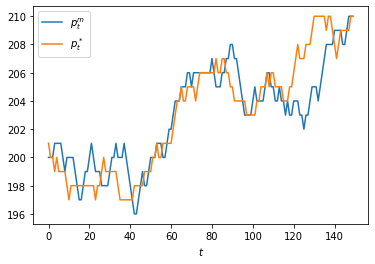

In [76]:
# The prices from the final trading day
plt.plot(mm_prices); plt.plot(fundamental_price)
plt.xlabel('$t$'); plt.legend(['$p^m_t$','$p^*_t$'])
plt.show()

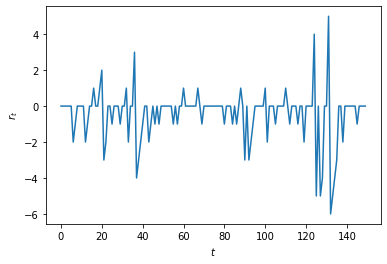

In [77]:
# The rewards in the final day
plt.plot(rewards)
plt.xlabel('$t$'); plt.ylabel('$r_t$')
plt.show()

In [79]:
np.mean(rewards)*MAX_T

-65.0